## Accessing Deltares global water availability on Azure

[Deltares](https://www.deltares.nl/en/) has produced a hydrological model approach to simulate historical daily reservoir variations for 3,236 locations across the globe for the period 1970-2020 using the distributed [wflow_sbm](https://deltares.github.io/Wflow.jl/dev/model/sbm/) model. The model outputs long-term daily information on reservoir volume, inflow and outflow dynamics, as well as information on upstream hydrological forcing.

They hydrological model was forced with 5 different precipitation products. Two products (ERA5 and CHIRPS) are available at the global scale, while for Europe, USA and Australia a regional product was use (i.e. EOBS, NLDAS and BOM, respectively). Using these different precipitation products, it becomes possible to assess the impact of uncertainty in the model forcing. A different number of basins upstream of reservoirs are simulated, given the spatial coverage of each precipitation product.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

Complete documentation for this dataset is available at <http://aka.ms/ai4edata-deltares-reservoirs>.

### Environment setup

In [1]:
import warnings

warnings.simplefilter("ignore")

import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5py
import h5netcdf

from dask.distributed import Client

### Create a local Dask cluster

Enable parallel reads and processing of data using Dask and xarray.

In [2]:
client = Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


### File access

The dataset is made up of five netCDF files, each corresponding to a different precipitation product for hydrological model forcing. Each variation covers a different spatial extent, with different number of reservoirs modeled. We'll choose one of the smaller files using a [BOM](http://www.bom.gov.au/) dataset covering Australia here. The other files available from the same root store are `reservoirs_CHIRPS`, `reservoirs_EOBS`, `reservoirs_ERA5`, and `reservoirs_NLDAS`.

We'll open the dataset and look at the variables and dimensions it contains.

In [3]:
root = "https://deltaresreservoirssa.blob.core.windows.net/reservoirs/v2021.12"
file = "reservoirs_BOM.nc"
path = f"{root}/{file}"

with fsspec.open(path) as f:
    ds = xr.open_dataset(f)

ds

<xarray.Dataset>
Dimensions:      (time: 14245, GrandID: 116, ksathorfrac: 5)
Coordinates:
  * time         (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2020-12-31
  * GrandID      (GrandID) int32 6675 6666 6662 6677 ... 6733 6605 6594 6706
  * ksathorfrac  (ksathorfrac) int32 5 20 50 100 250
Data variables: (12/14)
    latitude     (GrandID) float32 ...
    longitude    (GrandID) float32 ...
    P_res        (time, GrandID, ksathorfrac) float32 ...
    Ea_res       (time, GrandID, ksathorfrac) float32 ...
    Qout_res     (time, GrandID, ksathorfrac) float32 ...
    Qin_res      (time, GrandID, ksathorfrac) float32 ...
    ...           ...
    P            (time, GrandID, ksathorfrac) float32 ...
    ETa          (time, GrandID, ksathorfrac) float32 ...
    Snow         (time, GrandID, ksathorfrac) float32 ...
    Melt         (time, GrandID, ksathorfrac) float32 ...
    Temp         (time, GrandID, ksathorfrac) float32 ...
    PET          (time, GrandID, ksathorfrac) float32 ...

## Inspect the reservoirs

First, we'll plot a simple map of where all the modeled reservoirs are located in Australia.

(-46.045833587646484, -9.170833587646484)

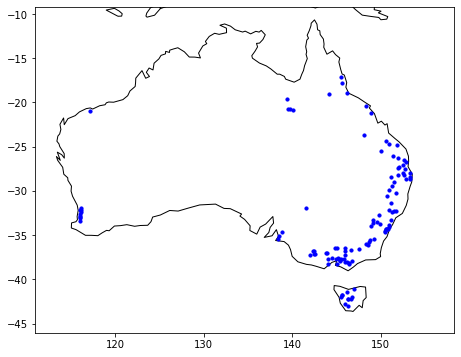

In [4]:
from shapely.geometry import MultiPoint
from IPython.display import GeoJSON
import geopandas as gpd

# Just interested in the GrandID dimension
df = ds.drop_dims(["time", "ksathorfrac"]).to_pandas()

# Generate a GeoSeries from just the coordinates
mp = MultiPoint(gpd.points_from_xy(df.longitude, df.latitude).to_numpy().tolist())
gs = gpd.GeoSeries(mp)

# Plot the points on a map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base_ax = world.plot(figsize=(10, 6), color='white', edgecolor='black')
ax = gs.plot(ax=base_ax, marker='o', color='blue', markersize=10);

# Zoom to bounds with some buffer
minx, miny, maxx, maxy = gs.total_bounds
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 3, maxy + 8)

#### Mean precipitation upstream of all reservoirs, single year

Now we'll pluck a single year in the series and plot the mean precipitation upstream of all the reservoir basins.

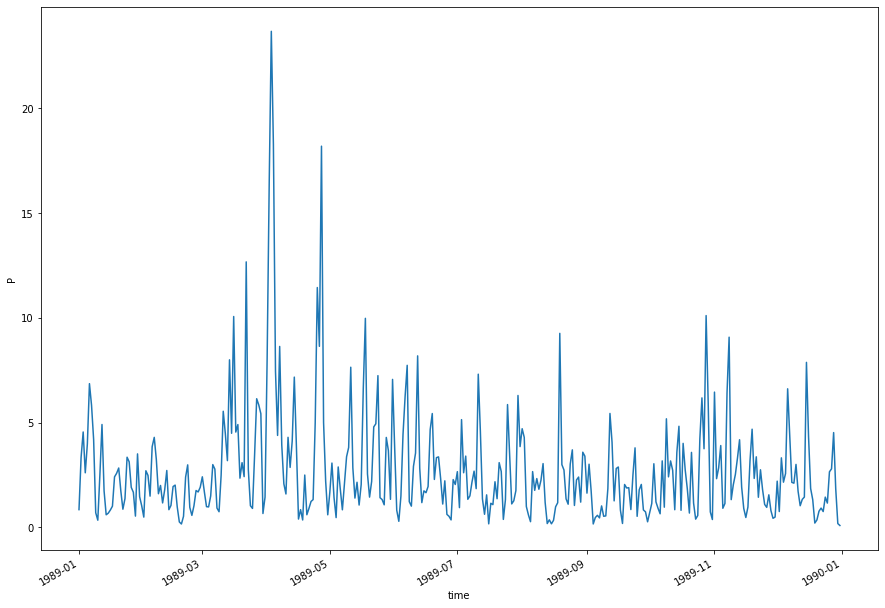

In [5]:
precip_yr = ds.P.sel(time="1989")
g = precip_yr.groupby("time")
p = g.mean(...).plot(figsize=(15,10))

## Inspect a single reservoir

We'll select the first reservoir by Id and a [KsatHorFrac](https://wflow.readthedocs.io/en/latest/wflow_sbm.html) of `50`. To get a sense of how the volume of water in the reservoir changes seasonally, let's plot the fraction of the reservoir that's full by month over the full time series.

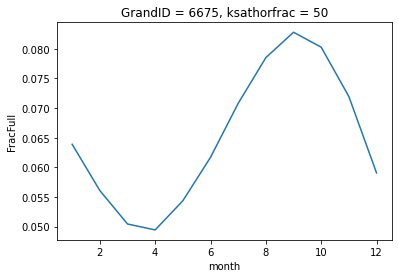

In [6]:
single_res = ds.sel(GrandID=ds.GrandID[0], ksathorfrac=50)
p = single_res.FracFull.groupby("time.month").mean().plot()

We can also check the volume directly over the course of the time series. This reservoir shows a sharp decrease in volume over time, according to the model.

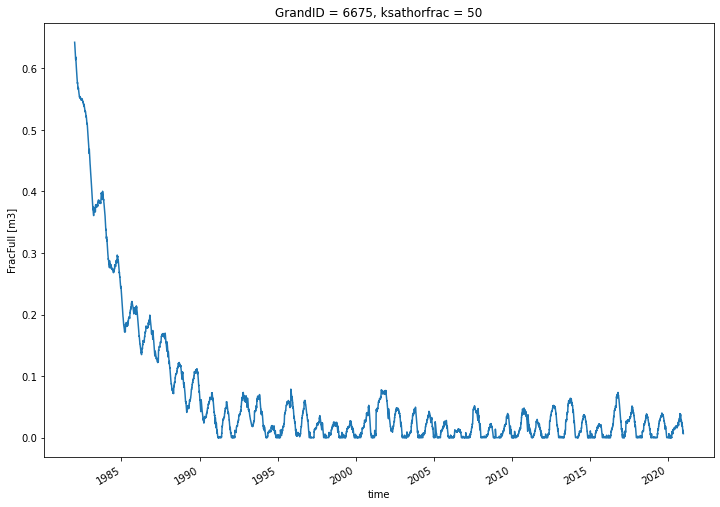

In [7]:
p = single_res.FracFull.plot(figsize=(12,8))

We can also plot other variables, daily, over the course of a single year.

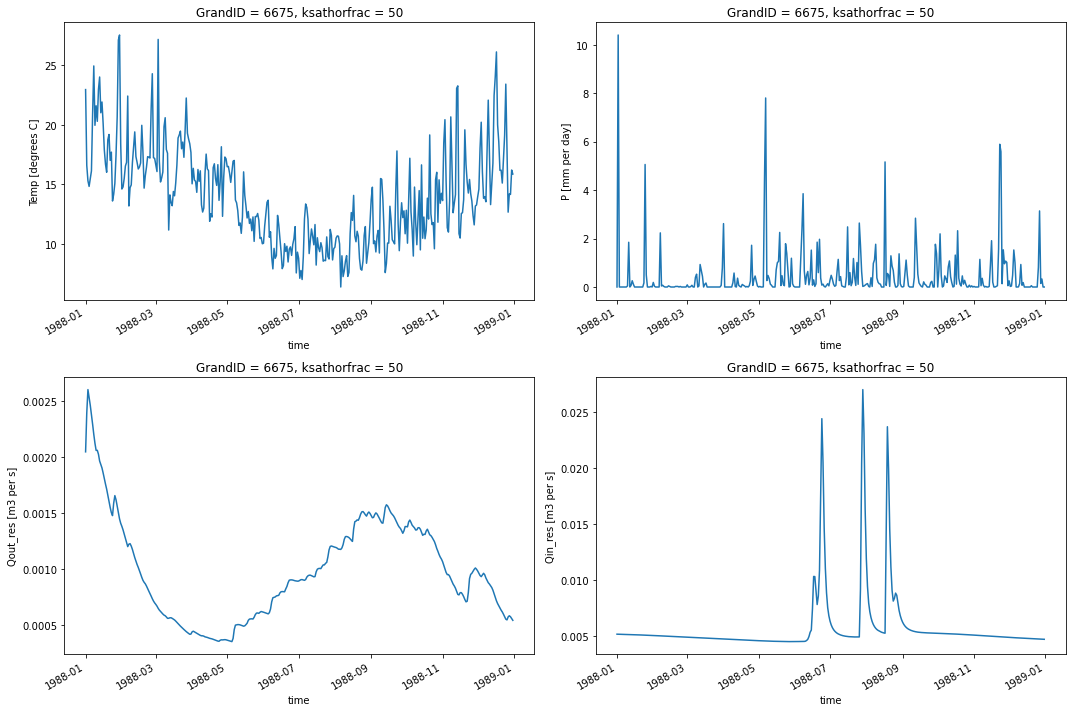

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))

year = single_res.sel(time="1988")

year.Temp.plot(ax=axes[0][0])
year.P.plot(ax=axes[0][1])
year.Qout_res.plot(ax=axes[1][0])
year.Qin_res.plot(ax=axes[1][1])

plt.tight_layout()
plt.draw()

### Observe the impact of KsatHorFrac

Here we'll select a new reservoir and plot how the different `KsatHorFrac` values affect volume in the model.

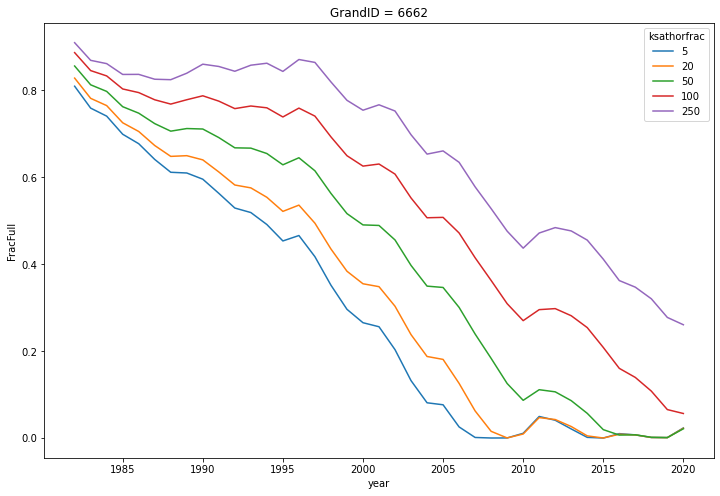

In [9]:
single_res_ksats = ds.sel(GrandID=6662).groupby("time.year").mean()
p = single_res_ksats.FracFull.plot.line(figsize=(12,8), hue="ksathorfrac", x="year")

## Inspect all reservoirs

We can also plot out all the reservoirs' `FracFull` variable and see how the different `KsatHorFrac` values affect volume in the model.

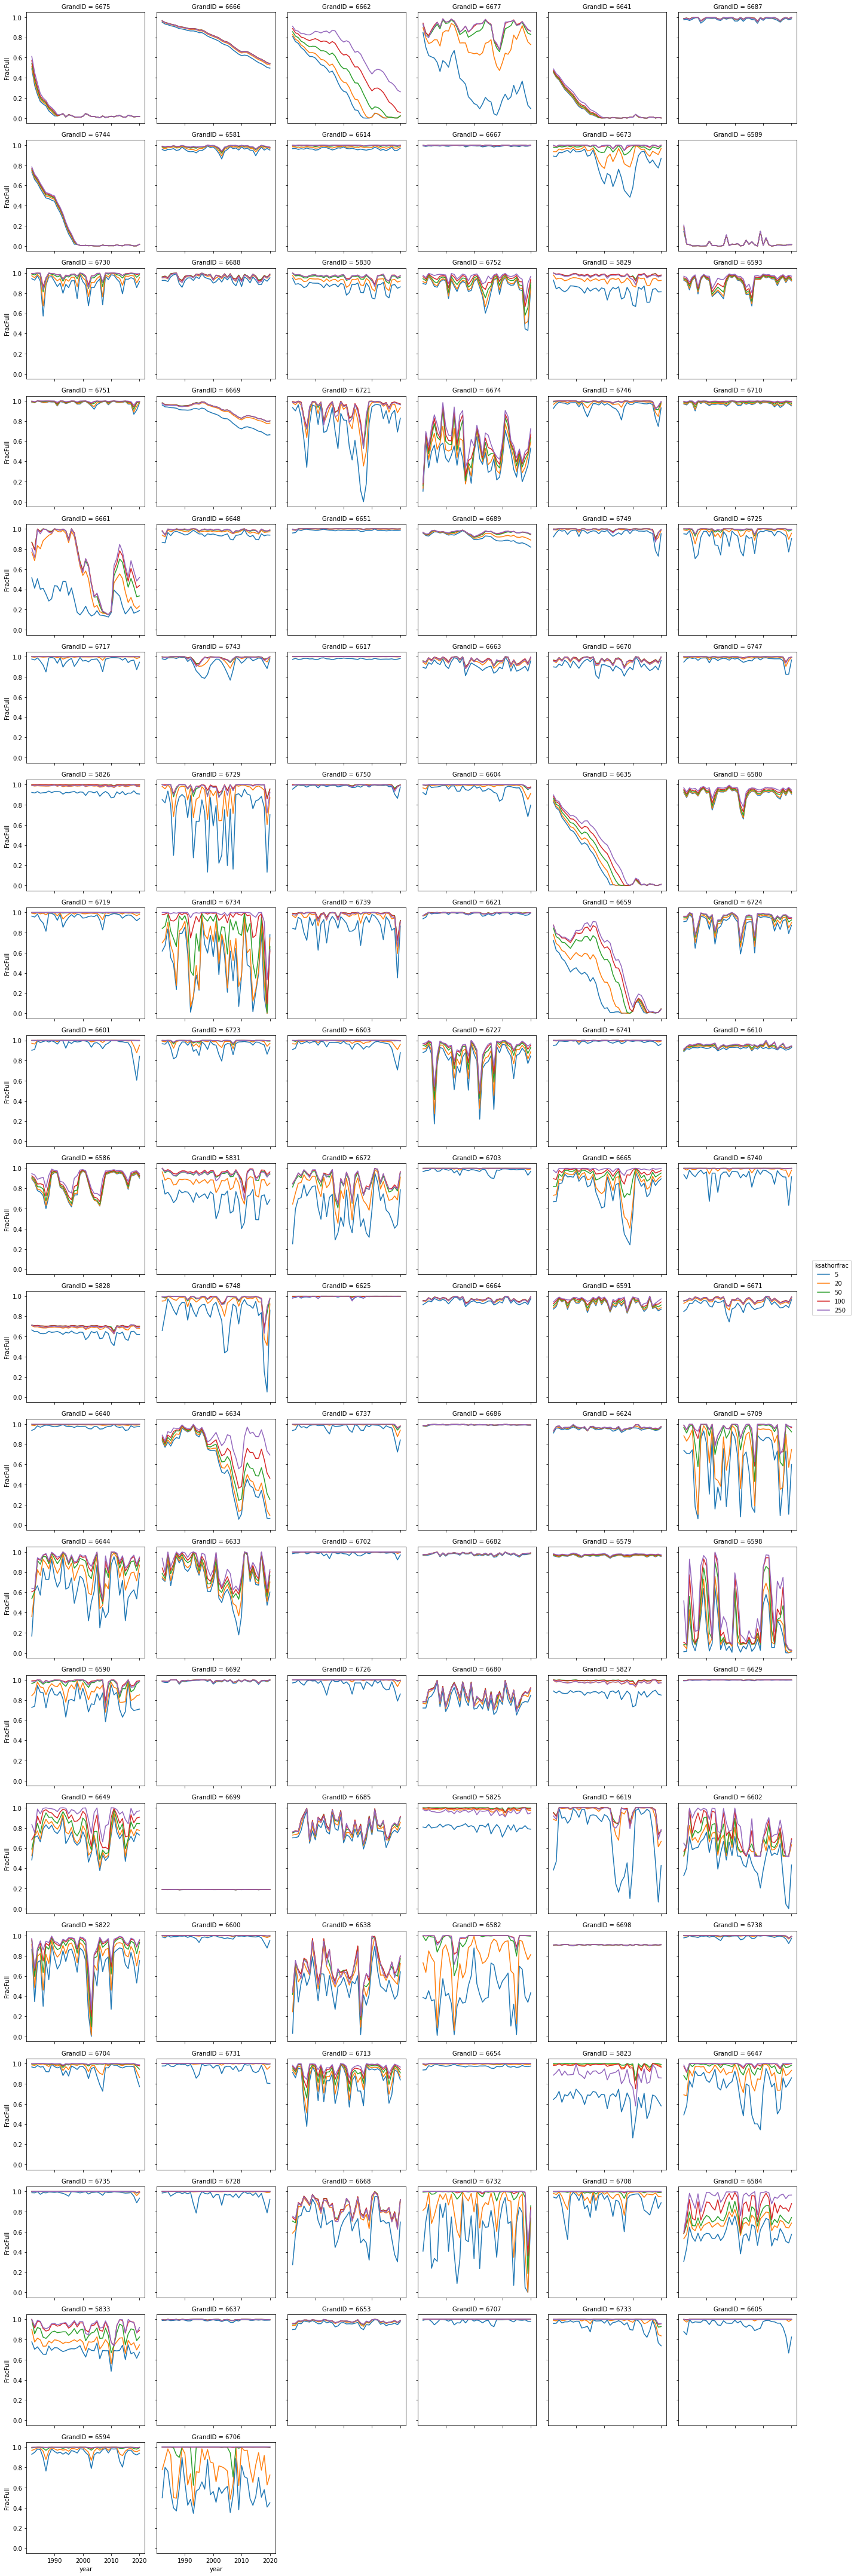

In [10]:
y = ds.FracFull.groupby("time.year").mean()
p = y.plot.line(col="GrandID", x="year", col_wrap=6)